In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
pd.options.display.max_columns = 999

In [3]:
df = pd.read_csv('mobile.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## Data Preparation

### Feature Selection

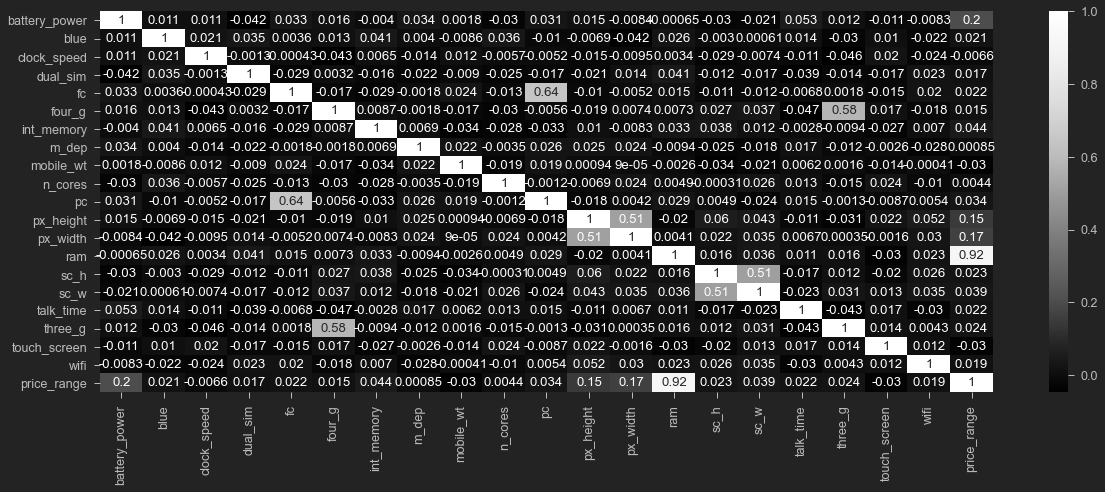

In [4]:
plt.figure(figsize = (20, 7) )
sns.heatmap(df.corr(), annot=True, cmap='Greys_r')
plt.show()

# Checking correlation between features and target feature

### Initial Hypothesis
- Ram has a positve correlation with price, its the highest than the others.
- battery power, px_height and width also shows a positive correlation with price
- I will determine the feature selection by combining the good correlation feature and base on my previous EDA

### Splitting Data

In [5]:
X = df.drop(columns=['price_range','blue','clock_speed','dual_sim','four_g','m_dep','sc_h','sc_w','talk_time','three_g','touch_screen','wifi'])
y = df.price_range

In [6]:
# Train Test Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=21)

In [7]:
# Checking the X_train features
X_train

,battery_power,fc,int_memory,mobile_wt,n_cores,pc,px_height,px_width,ram
1587,1093,1,31,171,2,12,1310,1420,1646
826,1788,15,2,150,6,20,472,1073,2655
811,807,9,8,158,5,20,667,697,1284
1500,1225,6,60,107,2,15,10,1567,2423
1824,1762,3,26,83,6,14,525,704,2661
...,...,...,...,...,...,...,...,...,...
919,1531,0,60,162,6,1,625,765,2524
440,1310,6,57,135,8,9,449,889,1175
1083,1330,11,37,126,7,20,1103,1637,2166
1702,1424,0,20,180,5,0,181,1199,2658


### Modelling

Base SVM

In [8]:
from sklearn.svm import SVC, SVR

In [9]:
baseSVC = SVC()
baseSVC.fit(X_train,y_train)
y_base_svc = baseSVC.predict(X_test)
y_train_svc = baseSVC.predict(X_train)

In [10]:
print(f'Train Accuracy Train: {(accuracy_score(y_train, y_train_svc)).round(2)}')
print(f'Test Accuracy Test: {(accuracy_score(y_test, y_base_svc)).round(2)}')

# After applying our first base model using SVM Classifier, it has the accuracy of test 0.96/ 96%!
# it's a good start with only base model we got a 96% accuracy now let see the precision recall and f1 score

Train Accuracy Train: 0.96
Test Accuracy Test: 0.96


In [11]:
# print(classification_report(y_train, y_train_svc),'\n')
print(classification_report(y_test, y_base_svc))
# prec_base_svm = (precision_score(y_test, y_base_svc, average='weighted')).round(2)
# rec_base_svm = recall_score(y_test, y_base_svc, average='weighted')

acc_base_svm = (accuracy_score(y_test, y_base_svc)).round(2)
acc_base_svm_train = (accuracy_score(y_train, y_train_svc)).round(2)

# Comparing the Classification report train and test
# With SVM, we can see the average score is also 0.96/96%

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.95      0.96      0.96       100
           2       0.94      0.95      0.95       100
           3       0.98      0.97      0.97       100

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.97       400
weighted avg       0.97      0.96      0.97       400



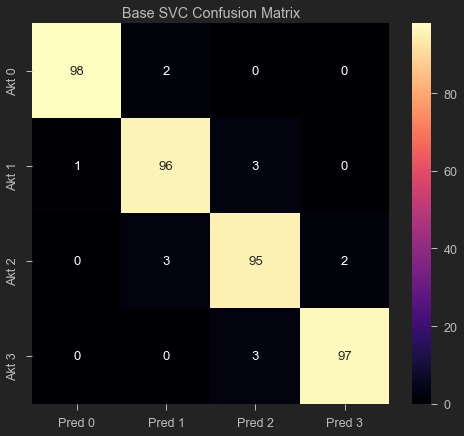

In [12]:
cm_base_svc = confusion_matrix(y_test, y_base_svc)
df_cm_base_svc = pd.DataFrame(data=cm_base_svc,columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_base_svc, annot=True, fmt='d',cmap='magma');
plt.title('Base SVC Confusion Matrix')
plt.show()

# Checking the confusion matrix
# we could see the error is already minimal both FN and FP, but we want to optimized the model into minimizing the error of FN => predict higher price but actual lower
# In order to prevent customers stop buying from us if they found out there are other place that sells it cheaper.

### Trying other model for comparison

Base Random Forest

In [13]:
baseRF = RandomForestClassifier()
baseRF.fit(X_train,y_train)
y_base_RF = baseRF.predict(X_test)
y_train_RF = baseRF.predict(X_train)

In [14]:
print(f'Accuracy Score Train: {accuracy_score(y_train, y_train_RF)}')
print(f'Accuracy Score Test: {accuracy_score(y_test, y_base_RF)}')
# prec_base_rf = (precision_score(y_test, y_base_RF, average='weighted')).round(2)
# rec_base_rf = recall_score(y_test, y_base_RF, average='weighted')

acc_base_rf = (accuracy_score(y_test, y_base_RF)).round(2)
acc_base_rf_train = (accuracy_score(y_train, y_train_RF)).round(2)

# The accuracy test score showing a 0.93 or 93% with accuracy train score of 1 or 100%.
# Since Random Forest is a complex algorithm, with only base model it is tend to overfit

Accuracy Score Train: 1.0
Accuracy Score Test: 0.9275


In [16]:
# prec_base_rf

In [17]:
# print(classification_report(y_train, y_train_RF))
print(classification_report(y_test, y_base_RF))

# The classification report shows the test score of precision, recall and f1_score are also 0.93 with train score 1

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       100
           1       0.93      0.87      0.90       100
           2       0.90      0.91      0.91       100
           3       0.96      0.95      0.95       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



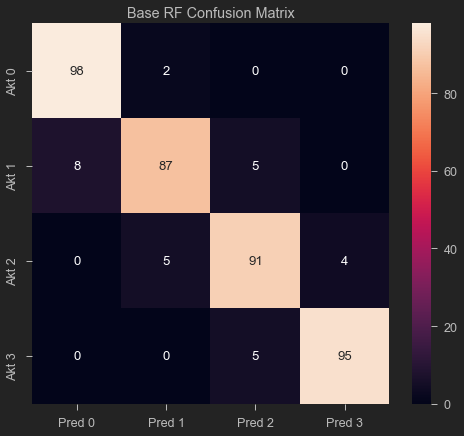

In [18]:
cm_base_rf = confusion_matrix(y_test, y_base_RF,)
df_cm_base_rf = pd.DataFrame(data=cm_base_rf, columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_base_rf, annot=True, fmt='d');
plt.title('Base RF Confusion Matrix')
plt.show()

# Checking the confusion matrix
# SVM base model perform better.

In [19]:
# plt.figure(figsize=(12,8))
# plt.yticks(size=15)

# feat_imp = pd.Series(baseRF.feature_importances_, X.columns).sort_values(ascending = True).tail(10)
# feat_imp.plot(kind = 'barh', title = 'Feature Importance')

BASE XGB

In [20]:
baseXGB = XGBClassifier()
baseXGB.fit(X_train,y_train)
y_base_XGB = baseXGB.predict(X_test)
y_train_XGB = baseXGB.predict(X_train)

In [21]:
print(f'Accuracy Train: {accuracy_score(y_train, y_train_XGB)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_base_XGB)}')
# prec_base_xgb = (precision_score(y_test, y_base_XGB, average='weighted')).round(2)
# rec_base_xgb = recall_score(y_test, y_base_XGB, average='weighted')

acc_base_xgb = (accuracy_score(y_test, y_base_XGB)).round(2)
acc_base_xgb_train = (accuracy_score(y_train, y_train_XGB)).round(2)

# The accuracy of test score is 0.94
# Similar to Random Forest, XGB also a more complex algorithm and with only base model it tend to overfit

Accuracy Train: 1.0
Accuracy Score: 0.94


In [22]:
# print(classification_report(y_train, y_train_XGB))
print(classification_report(y_test, y_base_XGB))

# The classification report also shows the average score is 0.94

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.92      0.94      0.93       100
           2       0.91      0.91      0.91       100
           3       0.96      0.94      0.95       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



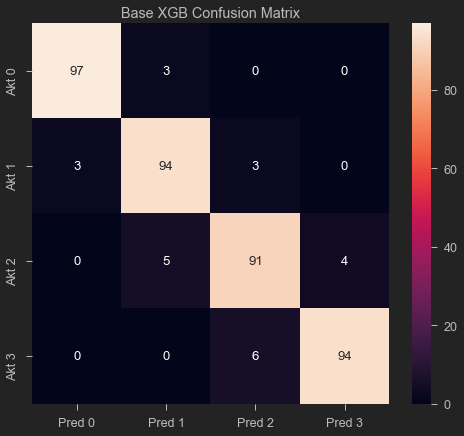

In [23]:
cm_base_xgb = confusion_matrix(y_test, y_base_XGB)
df_cm_base_xgb = pd.DataFrame(data=cm_base_xgb, columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_base_xgb, annot=True, fmt='d');
plt.title('Base XGB Confusion Matrix')
plt.show()

# Checking the confusion matrix
# XGB performs slightly better than Random Forest

## OPTIMIZE MODEL

### Scalling
- Because the scale of some of the features are different, we need to try to rescale it.

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [25]:
rob = RobustScaler()
X_train_rob = rob.fit_transform(X_train)
X_test_rob = rob.fit_transform(X_test)

In [26]:
baseSVC_scaled = SVC()
baseSVC_scaled.fit(X_train_rob,y_train)
y_base_svc_rob = baseSVC_scaled.predict(X_test_rob)
y_train_svc_rob = baseSVC_scaled.predict(X_train_rob)

In [27]:
print(f'Accuracy Train: {accuracy_score(y_train, y_train_svc_rob)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_base_svc_rob)}')

Accuracy Train: 0.973125
Accuracy Score: 0.9075


In [28]:
print(classification_report(y_test, y_base_svc_rob))
# print(classification_report(y_train, y_train_svc_rob))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       100
           1       0.88      0.86      0.87       100
           2       0.84      0.90      0.87       100
           3       1.00      0.89      0.94       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



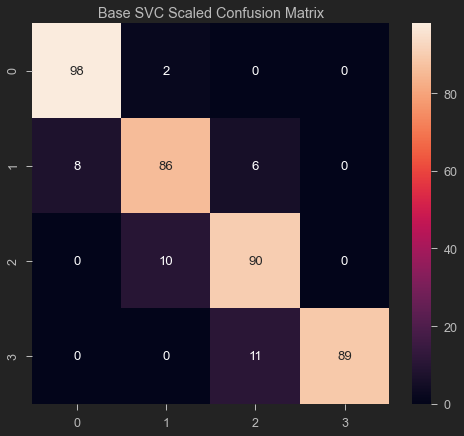

In [29]:
cm_base_svc_scaled = confusion_matrix(y_test, y_base_svc_rob)
df_cm_base_svc_scaled = pd.DataFrame(data=cm_base_svc_scaled)
sns.heatmap(df_cm_base_svc_scaled, annot=True, fmt='d');
plt.title('Base SVC Scaled Confusion Matrix')
plt.show()

In [ ]:
baseXGB_scaled = XGBClassifier()
baseXGB_scaled.fit(X_train_rob,y_train)
y_base_XGB_scaled = baseXGB_scaled.predict(X_test_rob)
y_train_XGB_scaled = baseXGB_scaled.predict(X_train_rob)

In [ ]:
print(f'Accuracy Train: {accuracy_score(y_train, y_train_XGB_scaled)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_base_XGB_scaled)}')

In [ ]:
print(classification_report(y_test, y_base_XGB_scaled))
print(classification_report(y_train, y_train_XGB_scaled))

In [ ]:
cm_base_xgb_scaled = confusion_matrix(y_test, y_base_XGB_scaled)
df_cm_base_xgb_scaled = pd.DataFrame(data=cm_base_xgb_scaled, columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_base_xgb_scaled, annot=True, fmt='d');
plt.title('Base XGB scaled Confusion Matrix')
plt.show()

### Hyper Parameter Tuning

SVM Hyper Parameter Tuning

In [133]:
# Tuning to optimize the SVM model.

SVM_tuned = SVC()
param_svm = {
    "C" : [1,0.75,.7],
    "kernel" : ['rbf', 'linear', 'poly', 'sigmoid'],
    "gamma" : ['scale','auto',1, .5, 2,5,7],
    'max_iter': [100,500,100],
    'decision_function_shape':['ovo', 'ovr']
}

In [134]:
# using GridSearchCV to find best parameters

model_SVM = GridSearchCV(estimator=SVM_tuned, param_grid=param_svm, n_jobs = -1, cv = 7, verbose=1)
model_SVM.fit(X_train_rob, y_train)
model_SVM.best_params_

Fitting 7 folds for each of 504 candidates, totalling 3528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 3513 out of 3528 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3528 out of 3528 | elapsed:   24.6s finished
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'C': 1,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': 500}

In [135]:
SVM_Tuned = model_SVM.best_estimator_
y_tunedSVM = SVM_Tuned.predict(X_test_rob)
y_tunedSVM_train = SVM_Tuned.predict(X_train_rob)

In [136]:
print(f'Accuracy Train: {accuracy_score(y_train, y_tunedSVM_train)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_tunedSVM)}')
# prec_tuned_svm = (precision_score(y_test, y_tunedSVM, average='weighted')).round(2)
# rec_tuned_svm = recall_score(y_test, y_tunedSVM, average='weighted')

acc_tuned_svm = (accuracy_score(y_test, y_tunedSVM)).round(2)
acc_tuned_svm_train = (accuracy_score(y_train, y_tunedSVM_train)).round(2)

# The accuracy slightly drop from base model

Accuracy Train: 0.974375
Accuracy Score: 0.9475


In [137]:
# print(classification_report(y_train, y_tunedSVM_train))
print(classification_report(y_test, y_tunedSVM))

# But turns out the recall score is increase.

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.91      0.95      0.93       100
           2       0.92      0.91      0.91       100
           3       1.00      0.93      0.96       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



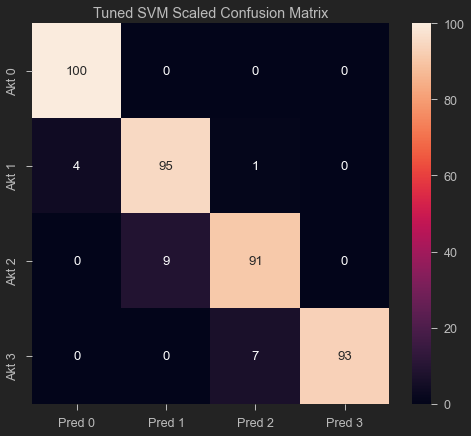

In [138]:
cm_tuned_svm = confusion_matrix(y_test, y_tunedSVM)
df_cm_tuned_svm_scaled = pd.DataFrame(data=cm_tuned_svm,columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_tuned_svm_scaled, annot=True, fmt='d');
plt.title('Tuned SVM Scaled Confusion Matrix')
plt.show()

# from the confusion matrix we could see the error in FN is decrease to zero, just like we wanted it to.

Random Forest Hyper Parameter Tuning

In [36]:
RF_tuned = RandomForestClassifier()
param_RF = {"n_estimators" : [100,500],
          "max_depth" : [1,5],
          "min_samples_split" : [10,8],
          "min_samples_leaf" : [2,4,5,3],
          "max_features" : ['auto',.75,.8]}

In [37]:
model_RF_Tuned = GridSearchCV(estimator=RF_tuned, param_grid=param_RF,cv=5, n_jobs=-1, verbose=1)
model_RF_Tuned.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 5],
                         'max_features': ['auto', 0.75, 0.8],
                         'min_samples_leaf': [2, 4, 5, 3],
                         'min_samples_split': [10, 8],
                         'n_estimators': [100, 500]},
             verbose=1)

In [38]:
model_RF_Tuned.best_params_

{'max_depth': 5,
 'max_features': 0.75,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [39]:
RF_Tuned = model_RF_Tuned.best_estimator_
y_tunedRF = RF_Tuned.predict(X_test)
y_tunedRF_train = RF_Tuned.predict(X_train)

In [40]:
print(f'Accuracy Train: {accuracy_score(y_train, y_tunedRF_train)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_tunedRF)}')
# prec_tuned_rf = (precision_score(y_test, y_tunedRF, average='weighted')).round(2)
# rec_tuned_rf = recall_score(y_test, y_tunedRF, average='weighted')

acc_tuned_rf = (accuracy_score(y_test, y_tunedRF)).round(2)
acc_tuned_rf_train = (accuracy_score(y_train, y_tunedRF_train)).round(2)

# The accuracy score is decrease to 0.89 but not overfit.

Accuracy Train: 0.920625
Accuracy Score: 0.8825


In [41]:
print(classification_report(y_train, y_tunedRF_train))
print(classification_report(y_test, y_tunedRF))

# from the classification report also shows precision recall f1 score average are also 0.89

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       400
           1       0.88      0.89      0.88       400
           2       0.87      0.89      0.88       400
           3       0.97      0.95      0.96       400

    accuracy                           0.92      1600
   macro avg       0.92      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       100
           1       0.88      0.79      0.83       100
           2       0.80      0.89      0.84       100
           3       0.96      0.89      0.92       100

    accuracy                           0.88       400
   macro avg       0.89      0.88      0.88       400
weighted avg       0.89      0.88      0.88       400



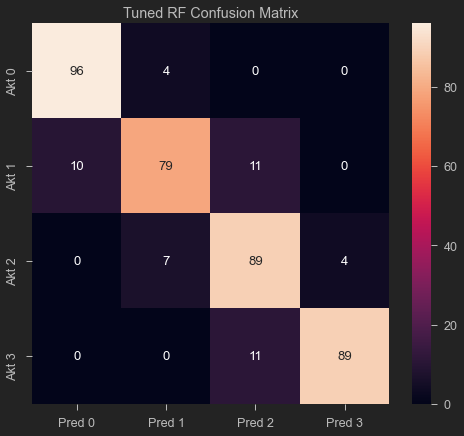

In [42]:
cm_tuned_rf = confusion_matrix(y_test, y_tunedRF)
df_cm_tuned_rf = pd.DataFrame(data=cm_tuned_rf,columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_tuned_rf, annot=True, fmt='d');
plt.title('Tuned RF Confusion Matrix')
plt.show()

# From the confusion matrix we could see the SVM performs better

In [43]:
# plt.figure(figsize=(12,8))
# plt.yticks(size=15)

# feat_imp = pd.Series(RF_Tuned.feature_importances_, X.columns).sort_values(ascending = True).tail(10)
# feat_imp.plot(kind = 'barh', title = 'Feature Importance')

XGB Hyper Parameter Tuning

In [44]:
XGB_tuned = XGBClassifier()
param_xgb = {'max_depth': [1,1.3,1.5] ,
             'learning_rate': [0.500000012] , 
             'n_estimators': [100,150], 
             'gamma': [0,.5,1], 
             'colsample_bytree': [1,.5] ,
             'subsample': [1,.1], 
             'reg_alpha': [1,.5],
             'reg_lambda': [1,.5]}

In [45]:
model_XGB_Tuned = GridSearchCV(estimator=XGB_tuned, param_grid=param_xgb,cv=5, n_jobs=-1, verbose=1)
model_XGB_Tuned.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   25.4s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [46]:
model_XGB_Tuned.best_params_

{'colsample_bytree': 1,
 'gamma': 0.5,
 'learning_rate': 0.500000012,
 'max_depth': 1,
 'n_estimators': 150,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'subsample': 1}

In [47]:
XGB_Tuned = model_XGB_Tuned.best_estimator_
y_tunedXGB = XGB_Tuned.predict(X_test)
y_tunedXGB_train = XGB_Tuned.predict(X_train)

In [48]:
print(f'Accuracy Train: {accuracy_score(y_train, y_tunedXGB_train)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_tunedXGB)}')
# prec_tuned_xgb = (precision_score(y_test, y_tunedXGB, average='weighted')).round(2)
# rec_tuned_xgb = recall_score(y_test, y_tunedXGB, average='weighted')

acc_tuned_xgb = (accuracy_score(y_test, y_tunedXGB)).round(2)
acc_tuned_xgb_train = (accuracy_score(y_train, y_tunedXGB_train)).round(2)

# XGB tuned the accuracy test scores are 0.93 and train score is 0.968, after tuning the model is not overfit.
# This model perform better than Random Forest

Accuracy Train: 0.96875
Accuracy Score: 0.93


In [49]:
print(classification_report(y_train, y_tunedXGB_train))
print(classification_report(y_test, y_tunedXGB))

# Classification report of precision recall f1 score average is also 0.93

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.95      0.95      0.95       400
           2       0.96      0.95      0.95       400
           3       0.99      0.99      0.99       400

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       100
           1       0.92      0.88      0.90       100
           2       0.89      0.92      0.91       100
           3       0.97      0.95      0.96       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



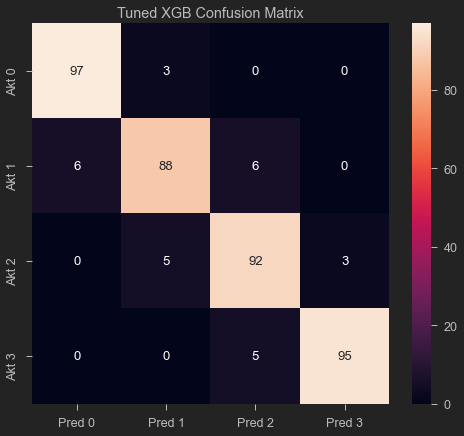

In [50]:
cm_tuned_xgb = confusion_matrix(y_test, y_tunedXGB)
df_cm_tuned_xgb = pd.DataFrame(data=cm_tuned_xgb,columns=['Pred 0','Pred 1','Pred 2','Pred 3'], index = ['Akt 0', 'Akt 1', 'Akt 2', 'Akt 3'])
sns.heatmap(df_cm_tuned_xgb, annot=True, fmt='d');
plt.title('Tuned XGB Confusion Matrix')
plt.show()

# from Confusion matrix we can see there were still an error on FN

In [139]:
data={
    'SVM': [acc_base_svm_train,acc_base_svm],
    'RF': [acc_base_rf_train, acc_base_rf],
    'XGB': [acc_base_xgb_train, acc_base_xgb],
    'SVM_tuned_scaled': [acc_tuned_svm_train, acc_tuned_svm],
    'RF_tuned': [acc_tuned_rf_train, acc_tuned_rf],
    'XGB_tuned': [acc_tuned_xgb_train, acc_tuned_xgb]
}

pd.DataFrame(data, index=['Accuracy Train','Accuracy Test']).T

,Accuracy Train,Accuracy Test
SVM,0.96,0.96
RF,1.00,0.93
XGB,1.00,0.94
SVM_tuned_scaled,0.97,0.95
RF_tuned,0.92,0.88
XGB_tuned,0.97,0.93


SVM base model for both train and test are the accuracy score is performs the best, but since my priority is to reduce errors of FN the SVM with Hyper Parameter Tuning performs the best 

### Comparing y_test Predict vs Actual

In [52]:
svm_model = pd.DataFrame(X_test_rob, columns=["battery_power","fc","int_memory","mobile_wt","n_cores","pc","px_height","px_width","ram"])

In [53]:
svm_model["y_true"] = y_test.values
svm_model["y_pred"] = y_tunedSVM

In [54]:
# svm_model
# We could see the model does not predict phone is higher than the actual
# the error were model predict lower price but the actual price is higher

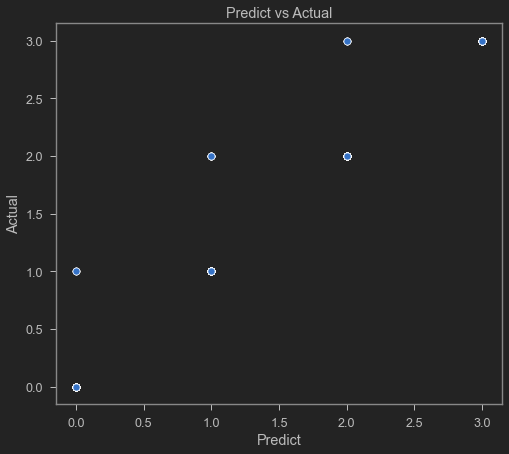

In [55]:
sns.scatterplot(data=svm_model, x='y_pred', y= 'y_true');
plt.title('Predict vs Actual')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [56]:
svm_model['error'] = abs(svm_model['y_true'] - svm_model['y_pred'])
svm_model['error'].value_counts(normalize=True)*100

# The total count error of data test from the model prediction in percentage is 5%.

0    95.0
1     5.0
Name: error, dtype: float64

# CONCLUSION
- SVM Hyper Parameter Tuning are the best model to predict/estimate of the mobile phone price.
- Model built focusing on minimizing the error on the FN => predict higher price but actual is lower price, in order to prevent customers stop buying from us if they found out the other places sells it cheaper.
- The Total Error percentage from data test is only 5%, turns out the model performs really well to predict/estimate the mobile phone price.